# Generate figures

The script below runs the model, outputs the results, and generates figures.

Last updated: 4 November 2019

## 1. Import ecohydro model

Model is saved as `runmodel.py` in folder. Evaporation and transpiration are seperated to calculate ET. Visualize preliminary figures.

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
#!pwd
#os.chdir("../")

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel

In [2]:
# initialize objects
climate = Climate() # uses default climate values
soil = Soil('loam')
crop = Crop(soil=soil)
soil.set_nZr(crop)  
model = CropModel(crop=crop,soil=soil,climate=climate)

model.run()
model.output()

done


,kc,LAI,R,s,E,ET,T,L,dsdt
0,0.300000,0.750000,0.000000,0.300000,0.099097,0.099097,0.000000,0.0,-0.099097
1,0.300000,0.750000,6.097618,0.299561,0.098010,0.098010,0.000000,0.0,5.999608
2,0.300000,0.750000,0.000000,0.326166,0.170545,0.170545,0.000000,0.0,-0.170545
3,0.300000,0.750000,5.540321,0.325410,0.168305,0.168305,0.000000,0.0,5.372016
4,0.300000,0.750000,0.000000,0.349233,0.243423,0.317872,0.074449,0.0,-0.317872
5,0.300000,0.750000,1.861813,0.347823,0.238726,0.307719,0.068993,0.0,1.554094
6,0.300000,0.750000,0.000000,0.354715,0.261976,0.357647,0.095670,0.0,-0.357647
7,0.300000,0.750000,0.000000,0.353129,0.256562,0.346093,0.089531,0.0,-0.346093
8,0.300000,0.750000,0.000000,0.351594,0.251359,0.334949,0.083590,0.0,-0.334949
9,0.300000,0.750000,3.992639,0.350109,0.246357,0.324197,0.077840,0.0,3.668441


## 2. Make figures

In [3]:
# Set directory for exporting figures
#os.chdir('output/figures')

# Set variables for all figures
s = np.arange(0, 1, 0.0056) #saturation
d = np.arange(1, 180, 1) #day
rs = np.linspace(0, 1, 180, endpoint=True) #relative soil moisture

0.64


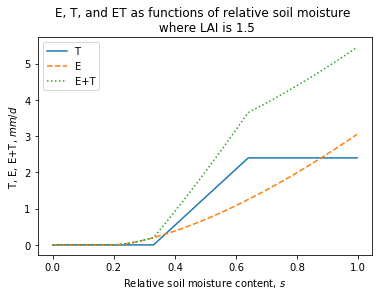

In [23]:
# Relative soil moisture, transpiration, and evaporation
# TODO: Need to plot for multiple LAIs: Total ET at various LAIs

def plot_s_et(s, lai):
    plt.plot(s, [crop.calc_T(x, LAI=lai) for x in s], '-')
    plt.plot(s, [climate.calc_E(x, q=1.5, LAI=lai, sh=0.2) for x in s],'--')
    plt.plot(s, [crop.calc_T(x, LAI=lai) + climate.calc_E(x, q=1.5, LAI=lai, sh=0.2) for x in s],':')

    plt.title('E, T, and ET as functions of relative soil moisture \n where LAI is %s' %lai)
    plt.xlabel('Relative soil moisture content, $\mathit{s}$')
    plt.ylabel('T, E, E+T, $\mathit{mm/d}$')
    plt.legend(['T', 'E','E+T'])

plot_s_et(s, lai=1.5)
print(crop.s_star)

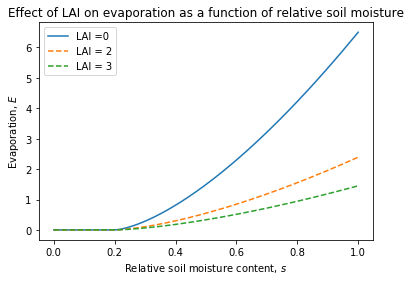

In [37]:
# Relationship between s and E

# TODO: Plot calc_E for different LAIs; Calcuate E_max before plotting calc_E

def plot_s_e(LAI1, LAI2, LAI3):

    plt.plot(rs, [climate.calc_E(s, q=1.5, LAI=LAI1, sh=0.2) for s in rs], '-') 
    plt.plot(rs, [climate.calc_E(s, q=1.5, LAI=LAI2, sh=0.2) for s in rs], '--')
    plt.plot(rs, [climate.calc_E(s, q=1.5, LAI=LAI3, sh=0.2) for s in rs], '--')
    plt.title('Effect of LAI on evaporation as a function of relative soil moisture')
    plt.xlabel('Relative soil moisture content, $\mathit{s}$')
    plt.ylabel('Evaporation, $\mathit{E}$')
    plt.legend(['LAI = %i'%LAI1,'LAI = %i' %LAI2,'LAI = %i' %LAI3])
    #plt.axhline(y=6.5, color='black', linewidth=1.5)
    
plot_s_e(0, 2, 3)

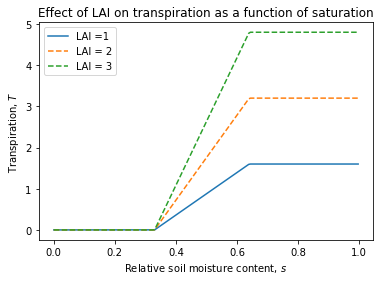

In [21]:
# Relationship between s and T
# TODO: Want this in terms of LAI: Currently in terms of DOS!

def plot_s_t(LAI1, LAI2, LAI3):

    plt.plot(s, [crop.calc_T(x, LAI1) for x in s], '-') 
    plt.plot(s, [crop.calc_T(x, LAI2) for x in s], '--')
    plt.plot(s, [crop.calc_T(x, LAI3) for x in s], '--')
    plt.title('Effect of LAI on transpiration as a function of saturation')
    plt.xlabel('Relative soil moisture content, $\mathit{s}$')
    plt.ylabel('Transpiration, $\mathit{T}$')
    plt.legend(['LAI =%i'%LAI1,'LAI = %i' %LAI2,'LAI = %i' %LAI3])
    #plt.axhline(y=6.5, color='black', linewidth=1.5)
    
plot_s_t(1, 2, 3)

What is hygroscopic point for loam soil?: 0.24 
What is field capacity for loam soil?: 0.69


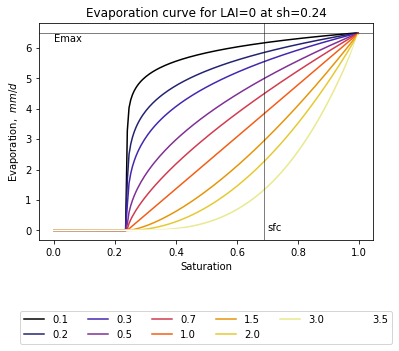

In [24]:
# Evaporation curve for loam soil sh = 0.24

def evap_loam(lsh, lsfc, lai):

    print('What is hygroscopic point for loam soil?:', lsh, '\n'
        'What is field capacity for loam soil?:', lsfc)

    # Make E curve for sh = 0.24
    #lsh, lsfc, lai = soil.sh, soil.sfc, 0

    qs = [0.1, 0.2, 0.3,  0.5, 0.7, 1.0, 1.5,  2.0, 3.0, 3.5]
    cs= plt.get_cmap('CMRmap') # see here: https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    colors = iter(cs(np.linspace(0,1,len(qs))))

    for q in qs:
        plt.plot(s,[climate.calc_E(x, q=q, LAI=lai, sh=lsh) for x in s], color=next(colors))

    plt.title('Evaporation curve for LAI={lai} at sh={lsh}'.format(lai=lai, lsh=lsh))
    plt.ylabel('Evaporation,  $\mathit{mm/d}$')
    plt.xlabel('Saturation')
    lgd = plt.legend(qs, loc=10, bbox_to_anchor=(0.5,-0.4), ncol=6)

    lsh, lsfc, lai = 0, soil.sfc, 0

    plt.axhline(y=6.5, color='black', linewidth=0.5, linestyle='-')
    plt.text(0,6.2,'Emax') #rotation=90
    plt.axvline(x=lsfc, color='black', linewidth=0.5, linestyle='-')
    plt.text(lsfc+0.01,0,'sfc') #rotation=90

evap_loam(lsh = soil.sh, lsfc = soil.sfc, lai = 0)

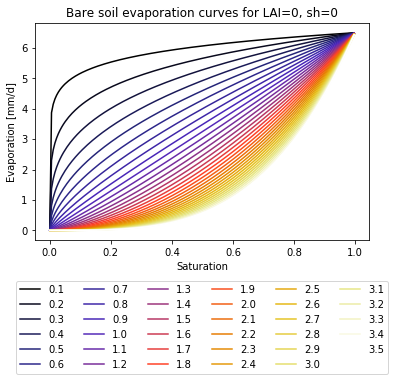

In [25]:
# Make E curves for sh = 0

def evap_loam(qs):

    lsh, lsfc, lai = 0, soil.sfc, 0

    cs= plt.get_cmap('CMRmap') # see here: https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    colors = iter(cs(np.linspace(0,1,len(qs))))

    for q in qs:
        plt.plot(s,[climate.calc_E(x, q=q, LAI=lai, sh=lsh) for x in s], color=next(colors))
        
    plt.title('Bare soil evaporation curves for LAI={lai}, sh={lsh}'.format(lai=lai, lsh=lsh))
    plt.ylabel('Evaporation [mm/d]')
    plt.xlabel('Saturation')
    lgd = plt.legend(qs, loc=10, bbox_to_anchor=(0.5,-0.4), ncol=6)
    # Saave this to a better place
    #plt.savefig('BareSoilEvap.eps', format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
    # white shows up funky

qs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5]

evap_loam(qs)


Justification: q=1.5, LAI=0 means evaporation increases linearly with soil moisture
As q increases, e.g. q=3, evaporation proceeds faster when soil is saturat


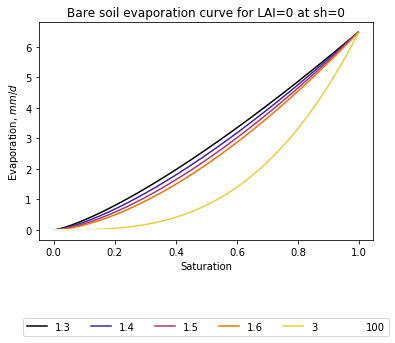

In [26]:
# Simple bare soil evap curve

def evap_loam_simple(lsh, lsfc, lai):

    qs = [1.3, 1.4, 1.5, 1.6, 3, 100]
    cs= plt.get_cmap('CMRmap') # see here: https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    colors = iter(cs(np.linspace(0,1,len(qs))))

    for q in qs:
        plt.plot(s,[climate.calc_E(x, q=q, LAI=lai, sh=lsh) for x in s], color=next(colors))
        
    plt.title('Bare soil evaporation curve for LAI={lai} at sh={lsh}'.format(lai=lai, lsh=lsh))
    plt.ylabel('Evaporation, $\mathit{mm/d}$')
    plt.xlabel('Saturation')
    plt.legend(qs, loc=10, bbox_to_anchor=(0.5,-0.4), ncol=6)

    print('Justification: q=1.5, LAI=0 means evaporation increases linearly with soil moisture')
    print('As q increases, e.g. q=3, evaporation proceeds faster when soil is saturat')

evap_loam_simple(lsh = 0, lsfc = soil.sfc, lai = 0)

In [54]:
# LAI and evporation

def plot_LAI_E(x, y):

    plt.plot(x, y)
    plt.title('Relationship between LAI and E')
    plt.xlabel('LAI')
    plt.ylabel('E')

#plot_LAI_E(model.LAI, model.E)

In [28]:
# LAI and DOS
# This no longer works with new calc_LAI function.

#climate.ET_max
#climate.calc_E(np.arange(180), np.arange(180))
#crop.calc_LAI(np.arange(1,180))

#def plot_calc_LAI(d):
#    plt.plot(d, [crop.calc_LAI(s,p=1) for s in d], '-')
#    plt.plot(d, [crop.calc_LAI(s,p=2) for s in d], '--')
#    plt.title('Relationship between DOS and LAI')
#    plt.xlabel('Day of Season')
#    plt.ylabel('LAI')

#plot_calc_LAI(d)

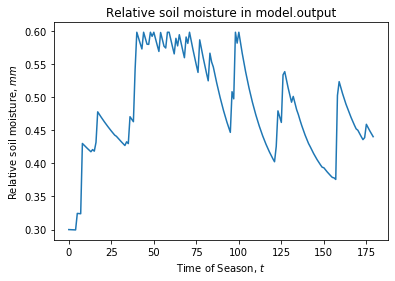

In [16]:
# Plot Time Series

def plot_ts(x, title, ylab):
    #d = np.arange(181)
    plt.plot(x, '-')
    plt.title(title)
    plt.xlabel('Time of Season, $\mathit{t}$')
    plt.ylabel(ylab)


# Evaporation and time
#plot_ts(model.E, 'Relationship between E and Time of Season', 'Evaporation, mm/day')

# S and time
o = model.output()
plot_ts(o['s'], 'Relative soil moisture in model.output', 'Relative soil moisture, $\mathit{mm}$')


In [ ]:
# Plot Liao 2001b Fig 5

In [ ]:
# Make max evap. rate fi

Text(0.5, 0, 'Kc')

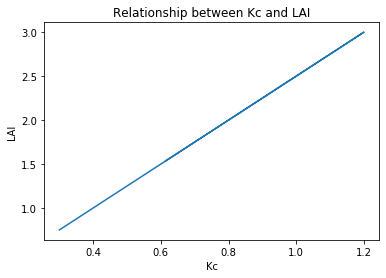

In [48]:
# Relationship between kc and LAI: Should be 1 to 1.

# kc and LAI: plant.calc_LAI
# Can input calc_LAI manually

crop = Crop(soil=soil)
crop.calc_LAI(100)

self = crop
self.T_max

self.sw

def calc_LAI(self, day_of_season, p=1):
        """ Returns a Leaf Area Index (LAI) variable. LAI comes
            from function of kc. Currently based on linear relationship 
            between kc and LAI (assumption).
        
        Usage: calc_LAI(t, p=1)

        LAI = (LAI_max/kc_max)^p * kc(t),

        where kc varies through the season according to calc_kc(t) 

        Note: p=1 assumes a linear relationship between LAI and kc

        """
        return pow((self.LAI_max/self.kc_max),p) * self.calc_kc(day_of_season)


#self.calc_LAI(1)

p=1
day_of_season = 1
pow((self.LAI_max/self.kc_max),p) * self.calc_kc(day_of_season)

self.calc_LAI(1)

plt.plot(model.kc, model.LAI)
plt.title('Relationship between Kc and LAI')
plt.ylabel('LAI')
plt.xlabel('Kc')


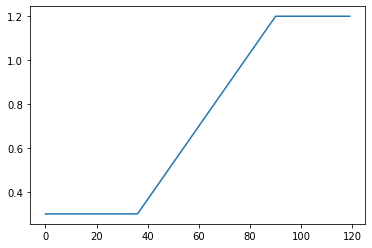

In [45]:
# Relationship between kc and DOY
N = 120
y = np.zeros(N)
yx = np.linspace(0, 120, N, endpoint=False)

plt.plot(yx, [crop.calc_kc(x) for x in yx], '-')
#plt.show()